In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendp
import math

# Enable opendp features
opendp is still on development mode so to use all the code you must fist.

In [2]:
from opendp.mod import enable_features
enable_features('contrib')

# Key Points
You don’t need to know all the details of the Programming Framework to write OpenDP applications, but it helps understand some of the key points:

   * OpenDP calculations are built by assembling a measurement from a number of constituent transformations and measurements, typically through chaining or composition.
    
    
   * Measurements don’t have a static privacy loss specified when constructing the measurement. Instead, measurements are typically constructed by specifying the scale of noise, and the loss is bounded by the resulting privacy relation. This requires some extra work compared to specifying the loss directly, but OpenDP provides some utilities to make this easier on the programmer, and the benefit is greatly increased flexibility of the framework as a whole.

In [3]:
from opendp.trans import make_identity
from opendp.typing import AllDomain, SymmetricDistance, Vec

identity = make_identity(D=VectorDomain[AllDomain[str]], M=SymmetricDistance)
identity(["Hello, world!"])
['Hello, world!']

NameError: name 'VectorDomain' is not defined

# Laplace Mechanism example

### Discrete Laplace Mechanism

Lets check is our mechanism is correct.  
We will first check the theoritical results

In [4]:
from opendp.meas import make_base_discrete_laplace

epsilon = 1.0 
sensitivity = 10
l = sensitivity / epsilon

In [5]:
# call the constructor to produce a measurement
discrete_laplace_mechanism = make_base_discrete_laplace(scale=l, D=AllDomain[int])

In [6]:
# investigate the privacy relation
is_private = discrete_laplace_mechanism.check(d_in=sensitivity, d_out=epsilon)
print(is_private)

True


In [7]:
l_tmp = l - 1

# call the constructor to produce a measurement
discrete_laplace_mechanism = make_base_discrete_laplace(scale=l_tmp)

# investigate the privacy relation
is_private = discrete_laplace_mechanism.check(d_in=sensitivity, d_out=epsilon)
print(is_private)

False


### make a private release

In [8]:
some_non_private_data = 5
private_release = discrete_laplace_mechanism(some_non_private_data)
private_release

5

In [9]:
some_non_private_data = [5,5,5,5]
private_release = [discrete_laplace_mechanism(datum) for datum in some_non_private_data]
private_release

[21, 6, 7, -5]

In [10]:
private_release = discrete_laplace_mechanism(some_non_private_data)
private_release

TypeError: inferred type is Vec<i32>, expected i32. See https://github.com/opendp/opendp/discussions/298

# Typing

now lets aplay a mechanism whit less noise that the theoritical results

In [11]:
from opendp.typing import VectorDomain
vectorized_discrete_laplace_mechanism = make_base_discrete_laplace(scale=l, D=VectorDomain[AllDomain[int]])

In [19]:
some_large_dataset = [5]*100
%timeit vectorized_discrete_laplace_mechanism(some_large_dataset)

6.59 ms ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
some_large_dataset = [5]*100
%timeit [discrete_laplace_mechanism(datum) for datum in some_large_dataset]

39.9 ms ± 51.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Continius Laplace Mechanism

In [34]:
from opendp.meas import make_base_laplace
# enable floating points if you want contrinius laplacian mechanism
enable_features("floating-point")

True

In [40]:
epsilon = 1.0 
sensitivity = 10.2
l = (sensitivity / epsilon)

# call the constructor to produce a measurement
laplace_mechanism = make_base_laplace(scale=l, D=VectorDomain[AllDomain[float]])

In [41]:
epsilon_2 = 0.5 
sensitivity_2 = 10.2
l_2 = (sensitivity_2 / epsilon_2)

# call the constructor to produce a measurement
laplace_mechanism_2 = make_base_laplace(scale=l_2, D=VectorDomain[AllDomain[float]])

In [48]:
some_non_private_input = [5.0]*1000
private_release = laplace_mechanism(some_non_private_input)
private_release_2 = laplace_mechanism_2(some_non_private_input)

In [49]:
import seaborn as sns

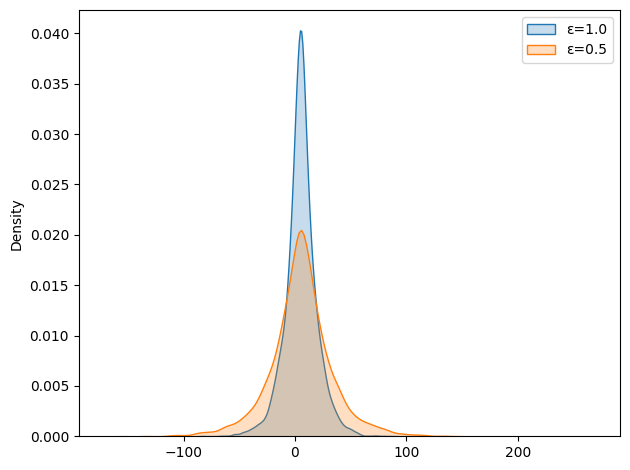

In [55]:
fig, ax = plt.subplots()
sns.kdeplot(private_release,label = f"ε={epsilon}",ax=ax,fill=True)
sns.kdeplot(private_release_2,label = f"ε={epsilon_2}",ax=ax,fill=True)
ax.legend()
plt.tight_layout()
plt.show()

# last week example

In [106]:
def logsequence(start, stop, num, base=10, decimals=2, asint=False):
    my_seq = np.linspace(start=math.log10(start), stop=math.log10(stop), num=num)
    my_seq = np.power(10, my_seq)
    if asint:
        my_seq = list(my_seq.round().astype(int))
    else:
        my_seq = my_seq.round(decimals=decimals)
    return my_seq

N_seq = logsequence(start=50, stop=800, num=8, asint=True)
epsilon_seq = logsequence(start=100, stop=0.01, num=4, decimals=2) 

In [107]:
print("Sequence of dataset sizes:  " + str(N_seq))
print("Sequence of epsilon values: " + str(epsilon_seq))

Sequence of dataset sizes:  [50, 74, 110, 164, 244, 362, 538, 800]
Sequence of epsilon values: [1.00e+02 4.64e+00 2.20e-01 1.00e-02]


# global privacy

In [70]:
def global_private_average(epsilon, data, domain_range):
    """
    implementation of the global private model of average function
    """
    N = data.shape[0]
    
    # 0. calulate average
    average = np.mean(data)
    
    # 1. create laplace mechanism
    sensitivity = domain_range/N
    l = (sensitivity / epsilon)
    laplace_mechanism = make_base_laplace(scale=l)
    
    # 2. calculate private release
    private_average = laplace_mechanism(average)
    
    return private_average

In [93]:
lower_value_x = 0
upper_value_x = 10

error_per_dataset = []
for N in N_seq:
    
    # generate data
    data_tmp = np.random.uniform(low = lower_value_x, 
                                 high = upper_value_x, 
                                 size = N)
    
    # average groundtruth
    average_value = np.mean(data_tmp)
    
    # create differential private release for different epsilon
    avg_error = []
    for epsilon in epsilon_seq:
        
        error_tmp = []
        # calculate error k times to get the average error
        for i in range(5):
            private_release = global_private_average(epsilon = epsilon,
                                                     data = data_tmp,
                                                     domain_range = upper_value_x - lower_value_x)
            error = abs(average_value-private_release)
            error_tmp += [error]
            
        avg_error += [np.mean(error_tmp)]
        
    error_per_dataset += [avg_error]

In [94]:
error_results = pd.DataFrame(error_per_dataset , columns = epsilon_seq, index = N_seq)

Text(0, 0.5, 'Absolute error')

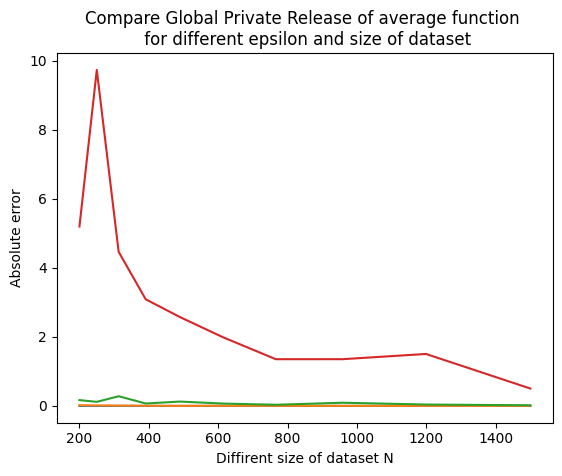

In [95]:
for e in error_results.columns:
    plt.plot(N_seq,error_results[e])
plt.title("Compare Global Private Release of average function \n for different epsilon and size of dataset")
plt.xlabel("Diffirent size of dataset N")
plt.ylabel("Absolute error")

Text(0, 0.5, 'log absolute error')

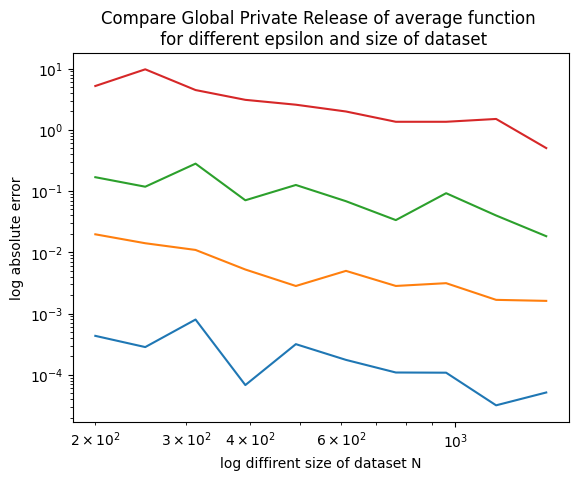

In [96]:
fig1, ax1 = plt.subplots()
for e in error_results.columns:
    plt.loglog(N_seq, error_results[e])
# ax1.set_xticks(N_seq)
plt.title("Compare Global Private Release of average function \n for different epsilon and size of dataset")
plt.xlabel("log diffirent size of dataset N")
plt.ylabel("log absolute error")

# 2. local privacy

In [97]:
def local_private_average(epsilon, data, domain_range):
    """
    implementation of the local private model of average function
    """
    N = data.shape[0]
    
    # 1. create laplace mechanism
    sensitivity = domain_range/N
    l = (sensitivity / epsilon)
    laplace_mechanism = make_base_laplace(scale=l, D=VectorDomain[AllDomain[float]])
    
    # 2. calculate private release
    private_dataset = laplace_mechanism(data)
    
    # 3. calulate average
    private_average = np.mean(private_dataset)
    
    return private_average

In [98]:
lower_value_x = 0
upper_value_x = 10

error_per_dataset = []
for N in N_seq:
    print(N)
    # generate data
    data_tmp = np.random.uniform(low = lower_value_x, 
                                 high = upper_value_x, 
                                 size = N)
    # average groundtruth
    average_value = np.mean(data_tmp)
    
    # create differential private release for different epsilon
    avg_error = []
    for epsilon in epsilon_seq:
            
        error_tmp = []
        # calculate error k times to get the average error
        for i in range(5):
            private_release = local_private_average(epsilon=epsilon,
                                                    data=data_tmp,
                                                    domain_range=upper_value_x-lower_value_x)
            error = abs(average_value-private_release)
            error_tmp += [error]
            
        avg_error += [np.mean(error_tmp)]
        
    error_per_dataset += [avg_error]

200
250
313
391
490
613
766
959
1199
1500


In [99]:
local_error_results = pd.DataFrame(error_per_dataset , columns = epsilon_seq, index = N_seq)

Text(0, 0.5, 'log absolute error')

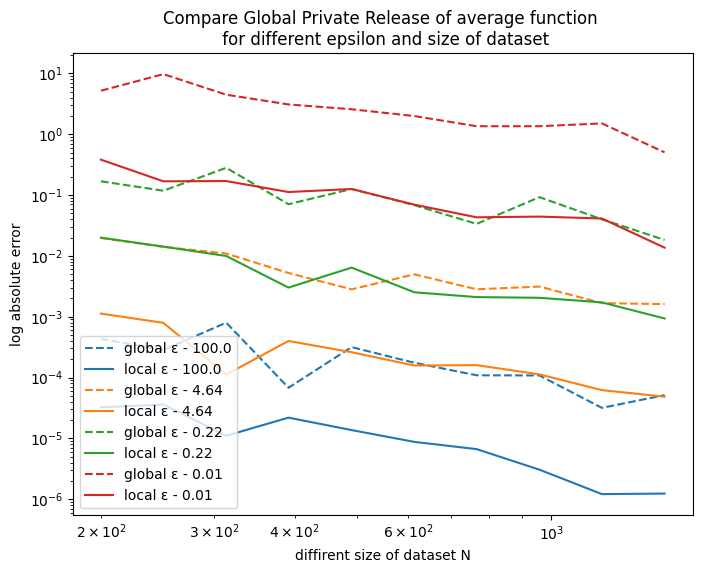

In [105]:
fig1, ax1 = plt.subplots(figsize = (8,6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i,e in enumerate(error_results.columns):
    plt.loglog(N_seq, error_results[e], "--",color=colors[i], label = f"global ε - {e}")
    plt.loglog(N_seq, local_error_results[e],color=colors[i], label = f"local ε - {e}")
# ax1.set_xticks(N_seq)
plt.legend()
plt.title("Compare Global Private Release of average function \n for different epsilon and size of dataset")
plt.xlabel("diffirent size of dataset N")
plt.ylabel("log absolute error")